In [1]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import tensorflow as tf
import time

In [2]:
# Define alphabets with uppercase English letters (A-Z), digits (0-9), and special characters
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789*^_)(- .',"
max_str_len = 34  # max length of input labels
num_of_characters = len(alphabets) + 1  # +1 for CTC pseudo blank
num_of_timestamps = 100  # max length of predicted labels

# Function to convert label (string) to numerical representation

def label_to_num(label):
    label_num = []
    for ch in label:
        idx = alphabets.find(ch)
        if idx == -1:  # This means the character is not found in the alphabet
            raise ValueError(f"Character '{ch}' not in alphabet.")
        label_num.append(idx)
    return np.array(label_num)


def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


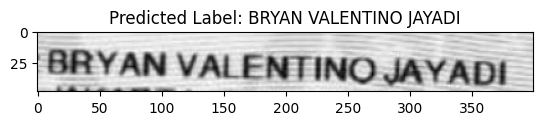

Predicted label: BRYAN VALENTINO JAYADI


In [3]:
# Load the model
model = tf.keras.models.load_model('C:/Adhi/code/capstone/arial.h5')
# Function to load, resize, rotate and preprocess the image
def preprocess_image(image_path, target_height=48, target_width=400):
    # Load the image using OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale (single channel)
    
    # Resize the image to the target dimensions (400x48)
    img_resized = cv2.resize(img, (target_width, target_height))
    
    # Normalize the image to [0, 1] range
    img_resized = img_resized / 255.0
    
    # Rotate the image 90 degrees clockwise
    img_resized = cv2.rotate(img_resized, cv2.ROTATE_90_CLOCKWISE)
    
    # Add batch and channel dimensions (for grayscale: (1, 400, 48, 1))
    img_resized = np.expand_dims(img_resized, axis=-1)  # Add channel dimension
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    
    return img_resized

# Load and preprocess the image
image_path = "C:/Adhi/code/capstone/synthetic_data/generated_images_arial/BRYAN VALENTINO JAYADI.jpg"  # Update with your image path
image = preprocess_image(image_path)

# Make the prediction
preds = model.predict(image)

# CTC Decode
input_length = np.ones(preds.shape[0]) * preds.shape[1]  # Use the length of the output sequence
decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(preds, input_length=input_length, greedy=True)[0][0])

# Convert the predicted labels back to text
prediction = num_to_label(decoded[0])

# Plot the image and display the predicted label
plt.imshow(cv2.rotate(image[0, :, :, 0], cv2.ROTATE_90_COUNTERCLOCKWISE), cmap='gray')
plt.title(f'Predicted Label: {prediction}')
plt.show()

# Print the prediction
print("Predicted label:", prediction)

### OUR MODEL BACTH ACCURACY TEST

In [4]:


# Preprocess image function
def preprocess_image(image_path, target_height=48, target_width=400):
    """
    Preprocess the image for the model.
    Args:
        image_path (str): Path to the image file.
        target_height (int): Target height of the image.
        target_width (int): Target width of the image.
    Returns:
        np.ndarray: Preprocessed image ready for model input.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    img_resized = cv2.resize(img, (target_width, target_height))  # Resize to target dimensions
    img_resized = img_resized / 255.0  # Normalize to [0, 1]
    img_resized = cv2.rotate(img_resized, cv2.ROTATE_90_CLOCKWISE)  # Rotate 90 degrees
    img_resized = np.expand_dims(img_resized, axis=-1)  # Add channel dimension
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    return img_resized

# Function to decode CTC predictions to text
def decode_ctc_predictions(preds, input_length):
    """
    Decodes CTC predictions to text using greedy decoding.
    Args:
        preds (np.ndarray): Predictions from the model.
        input_length (np.ndarray): Length of input sequences.
    Returns:
        list of str: Decoded text predictions.
    """
    decoded = tf.keras.backend.get_value(
        tf.keras.backend.ctc_decode(preds, input_length=input_length, greedy=True)[0][0]
    )
    return [num_to_label(seq) for seq in decoded]

# Function to compute accuracy for a folder of images with logging
def calculate_folder_accuracy(folder_path, model, target_height=48, target_width=400):
    """
    Calculates accuracy for all images in a folder.
    Args:
        folder_path (str): Path to the folder containing images.
        model (tf.keras.Model): Trained CTC model.
        target_height (int): Target height of the image.
        target_width (int): Target width of the image.
    Returns:
        float: Accuracy as a percentage.
    """
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    correct = 0
    total = len(image_files)

    start_time = time.time()  # Start timer

    for idx, image_file in enumerate(image_files, start=1):
        # Ground truth label from filename
        label = os.path.splitext(image_file)[0]  # Filename without extension
        try:
            label_num = label_to_num(label)  # Convert label to numerical form
        except ValueError as e:
            print(f"[{idx}/{total}] Skipping file {image_file}: {e}")
            continue

        # Preprocess the image
        image_path = os.path.join(folder_path, image_file)
        image = preprocess_image(image_path, target_height, target_width)

        # Predict using the model
        preds = model.predict(image)
        input_length = np.ones(preds.shape[0]) * preds.shape[1]  # Length of predicted sequence
        predictions = decode_ctc_predictions(preds, input_length)
        prediction = predictions[0] if predictions else ""

        # Log each prediction
        match_status = "CORRECT" if prediction == label else "WRONG"
        print(f"[{idx}/{total}] File: {image_file}")
        print(f"  - Ground Truth: {label}")
        print(f"  - Prediction:   {prediction}")
        print(f"  - Status:       {match_status}")

        # Check if prediction matches the label
        if prediction == label:
            correct += 1

    end_time = time.time()  # End timer

    accuracy = (correct / total) * 100 if total > 0 else 0
    runtime = end_time - start_time

    print(f"\nTotal Accuracy: {accuracy:.2f}%")
    print(f"Total Runtime: {runtime:.2f} seconds")

    return accuracy, runtime

# Main function to compute accuracy
if __name__ == "__main__":
    # Folder path with images
    folder_path = "C:/Adhi/code/capstone/test"  # Update this with your folder path

    # Load the trained model
    model = tf.keras.models.load_model('C:/Adhi/code/capstone/ar_ver4.h5')

    # Calculate accuracy
    accuracy, runtime = calculate_folder_accuracy(folder_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
[1/54] File: DESA KIAEA.jpg
  - Ground Truth: DESA KIAEA
  - Prediction:   DESA KIAEA
  - Status:       CORRECT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[2/54] File: DESA PAKU JAYA.jpg
  - Ground Truth: DESA PAKU JAYA
  - Prediction:   DE SA PAKU JAYA
  - Status:       WRONG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[3/54] File: DESA SIDOREJO.jpg
  - Ground Truth: DESA SIDOREJO
  - Prediction:   DESA SIDOREJO
  - Status:       CORRECT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[4/54] File: DESTRI WAHYUDIN.jpg
  - Ground Truth: DESTRI WAHYUDIN
  - Prediction:   DESTRI WAHYUDIN
  - Status:       CORRECT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[5/54] File: DEWI PRATIWI JAYA.jpg
  - Ground Truth: DEWI PRATIWI JAYA
  - Prediction:   DEWI PRATIWI JAYA
  - Status:       CORRECT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[6/54] File: DIANA CITRA.jpg
  - Ground Truth: DIANA CITRA
  - Prediction:   DIANA CITRA
  - Status:       CORRECT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[7

### PYTESSERACT-OCR MODEL BACTH ACCURACY TEST

In [5]:
import os
import cv2
import numpy as np
import pytesseract
from PIL import Image
import time

# Function to predict using Tesseract OCR (No preprocessing)
def predict_with_tesseract(image_path):
    """
    Predicts text from the image using Tesseract OCR.
    Args:
        image_path (str): Path to the image file.
    Returns:
        str: Text prediction from Tesseract.
    """
    # Read the image directly in grayscale (no preprocessing)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Convert the image to PIL format for pytesseract
    pil_img = Image.fromarray(img)
    
    # Use Tesseract to extract text
    text = pytesseract.image_to_string(pil_img, config='--psm 6').strip()
    return text

# Function to compute accuracy for a folder of images with logging (using Tesseract)
def calculate_folder_accuracy(folder_path):
    """
    Calculates accuracy for all images in a folder using Tesseract OCR.
    Args:
        folder_path (str): Path to the folder containing images.
    Returns:
        float: Accuracy as a percentage.
    """
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    correct = 0
    total = len(image_files)

    start_time = time.time()  # Start timer

    for idx, image_file in enumerate(image_files, start=1):
        # Ground truth label from filename
        label = os.path.splitext(image_file)[0]  # Filename without extension

        # Get the full path to the image file
        image_path = os.path.join(folder_path, image_file)

        # Predict using Tesseract
        prediction = predict_with_tesseract(image_path)

        # Log each prediction
        match_status = "CORRECT" if prediction == label else "WRONG"
        print(f"[{idx}/{total}] File: {image_file}")
        print(f"  - Ground Truth: {label}")
        print(f"  - Prediction:   {prediction}")
        print(f"  - Status:       {match_status}")

        # Check if prediction matches the label
        if prediction == label:
            correct += 1

    end_time = time.time()  # End timer

    accuracy = (correct / total) * 100 if total > 0 else 0
    runtime = end_time - start_time

    print(f"\nTotal Accuracy: {accuracy:.2f}%")
    print(f"Total Runtime: {runtime:.2f} seconds")

    return accuracy, runtime

# Main function to compute accuracy
if __name__ == "__main__":
    # Folder path with images
    folder_path = "C:/Adhi/code/capstone/test"  # Update this with your folder path

    # Calculate accuracy using Tesseract OCR
    accuracy, runtime = calculate_folder_accuracy(folder_path)


[1/54] File: DESA KIAEA.jpg
  - Ground Truth: DESA KIAEA
  - Prediction:   DESA KiAEA
  - Status:       WRONG
[2/54] File: DESA PAKU JAYA.jpg
  - Ground Truth: DESA PAKU JAYA
  - Prediction:   DESA PAKU JAYA
  - Status:       CORRECT
[3/54] File: DESA SIDOREJO.jpg
  - Ground Truth: DESA SIDOREJO
  - Prediction:   DESA SIDOREJO—
  - Status:       WRONG
[4/54] File: DESTRI WAHYUDIN.jpg
  - Ground Truth: DESTRI WAHYUDIN
  - Prediction:   
  - Status:       WRONG
[5/54] File: DEWI PRATIWI JAYA.jpg
  - Ground Truth: DEWI PRATIWI JAYA
  - Prediction:   DEW! PRATIWI JAYA
  - Status:       WRONG
[6/54] File: DIANA CITRA.jpg
  - Ground Truth: DIANA CITRA
  - Prediction:   ‘DIANA CITRA
  - Status:       WRONG
[7/54] File: DISHILDA FOURISTI.jpg
  - Ground Truth: DISHILDA FOURISTI
  - Prediction:   DISHILDA FOURISTI
  - Status:       CORRECT
[8/54] File: DRH.SELYTA MAYANG PINANG.jpg
  - Ground Truth: DRH.SELYTA MAYANG PINANG
  - Prediction:   DRH.SELYTA MAYANG PINANG
  - Status:       CORRECT
[9/5

### EASYOCR MODEL BACTH ACCURACY TEST

In [6]:
import os
import time
import easyocr

# Initialize the EasyOCR reader
reader = easyocr.Reader(['en'])  # Add languages as needed

# Function to predict using EasyOCR
def predict_with_easyocr(image_path):
    """
    Predicts text from the image using EasyOCR.
    Args:
        image_path (str): Path to the image file.
    Returns:
        str: Text prediction from EasyOCR.
    """
    # Use EasyOCR to extract text
    results = reader.readtext(image_path, detail=0)  # Extract text without box details

    # Combine the predictions (if multiple text boxes are detected)
    text = ' '.join(results).strip()
    return text

# Function to compute accuracy for a folder of images with logging (using EasyOCR)
def calculate_folder_accuracy(folder_path):
    """
    Calculates accuracy for all images in a folder using EasyOCR.
    Args:
        folder_path (str): Path to the folder containing images.
    Returns:
        float: Accuracy as a percentage.
    """
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    correct = 0
    total = len(image_files)

    start_time = time.time()  # Start timer

    for idx, image_file in enumerate(image_files, start=1):
        # Ground truth label from filename
        label = os.path.splitext(image_file)[0]  # Filename without extension

        # Get the full path to the image file
        image_path = os.path.join(folder_path, image_file)

        # Predict using EasyOCR
        prediction = predict_with_easyocr(image_path)

        # Log each prediction
        match_status = "CORRECT" if prediction == label else "WRONG"
        print(f"[{idx}/{total}] File: {image_file}")
        print(f"  - Ground Truth: {label}")
        print(f"  - Prediction:   {prediction}")
        print(f"  - Status:       {match_status}")

        # Check if prediction matches the label
        if prediction == label:
            correct += 1

    end_time = time.time()  # End timer

    accuracy = (correct / total) * 100 if total > 0 else 0
    runtime = end_time - start_time

    print(f"\nTotal Accuracy: {accuracy:.2f}%")
    print(f"Total Runtime: {runtime:.2f} seconds")

    return accuracy, runtime

# Main function to compute accuracy
if __name__ == "__main__":
    # Folder path with images
    folder_path = "C:/Adhi/code/capstone/test"  # Update this with your folder path

    # Calculate accuracy using EasyOCR
    accuracy, runtime = calculate_folder_accuracy(folder_path)


[1/54] File: DESA KIAEA.jpg
  - Ground Truth: DESA KIAEA
  - Prediction:   DESA KIAEA
  - Status:       CORRECT
[2/54] File: DESA PAKU JAYA.jpg
  - Ground Truth: DESA PAKU JAYA
  - Prediction:   DESA PAKU MYA
  - Status:       WRONG
[3/54] File: DESA SIDOREJO.jpg
  - Ground Truth: DESA SIDOREJO
  - Prediction:   DESA SIDORED
  - Status:       WRONG
[4/54] File: DESTRI WAHYUDIN.jpg
  - Ground Truth: DESTRI WAHYUDIN
  - Prediction:   DESRIWAHtuDtt
  - Status:       WRONG
[5/54] File: DEWI PRATIWI JAYA.jpg
  - Ground Truth: DEWI PRATIWI JAYA
  - Prediction:   Otmraatim
  - Status:       WRONG
[6/54] File: DIANA CITRA.jpg
  - Ground Truth: DIANA CITRA
  - Prediction:   DIANA CITRA
  - Status:       CORRECT
[7/54] File: DISHILDA FOURISTI.jpg
  - Ground Truth: DISHILDA FOURISTI
  - Prediction:   DISHILDA FQURIST
  - Status:       WRONG
[8/54] File: DRH.SELYTA MAYANG PINANG.jpg
  - Ground Truth: DRH.SELYTA MAYANG PINANG
  - Prediction:   Drh SELYTA MAYANG PINANG
  - Status:       WRONG
[9/54]

### PyOCR MODEL BACTH ACCURACY TEST

In [7]:
import os
import time
import pyocr
import pyocr.builders
from PIL import Image

# Initialize the OCR tool
tools = pyocr.get_available_tools()
if not tools:
    raise Exception("No OCR tool available. Please install Tesseract or another OCR library.")
tool = tools[0]  # Use the first available tool (typically Tesseract)

# Function to predict using pyocr
def predict_with_pyocr(image_path):
    """
    Predicts text from the image using pyocr.
    Args:
        image_path (str): Path to the image file.
    Returns:
        str: Text prediction from pyocr.
    """
    # Read the image using PIL
    image = Image.open(image_path)

    # Use pyocr to extract text from the image
    text = tool.image_to_string(
        image,
        lang='eng',  # Specify language, e.g., 'eng' for English
        builder=pyocr.builders.TextBuilder()  # Configure builder to return plain text
    )
    return text.strip()

# Function to compute accuracy for a folder of images with logging (using pyocr)
def calculate_folder_accuracy(folder_path):
    """
    Calculates accuracy for all images in a folder using pyocr.
    Args:
        folder_path (str): Path to the folder containing images.
    Returns:
        float: Accuracy as a percentage.
    """
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    correct = 0
    total = len(image_files)

    start_time = time.time()  # Start timer

    for idx, image_file in enumerate(image_files, start=1):
        # Ground truth label from filename
        label = os.path.splitext(image_file)[0]  # Filename without extension

        # Get the full path to the image file
        image_path = os.path.join(folder_path, image_file)

        # Predict using pyocr
        prediction = predict_with_pyocr(image_path)

        # Log each prediction
        match_status = "CORRECT" if prediction == label else "WRONG"
        print(f"[{idx}/{total}] File: {image_file}")
        print(f"  - Ground Truth: {label}")
        print(f"  - Prediction:   {prediction}")
        print(f"  - Status:       {match_status}")

        # Check if prediction matches the label
        if prediction == label:
            correct += 1

    end_time = time.time()  # End timer

    accuracy = (correct / total) * 100 if total > 0 else 0
    runtime = end_time - start_time

    print(f"\nTotal Accuracy: {accuracy:.2f}%")
    print(f"Total Runtime: {runtime:.2f} seconds")

    return accuracy, runtime

# Main function to compute accuracy
if __name__ == "__main__":
    # Folder path with images
    folder_path = "C:/Adhi/code/capstone/test"  # Update this with your folder path

    # Calculate accuracy using pyocr
    accuracy, runtime = calculate_folder_accuracy(folder_path)


[1/54] File: DESA KIAEA.jpg
  - Ground Truth: DESA KIAEA
  - Prediction:   DESA KiAEA
  - Status:       WRONG
[2/54] File: DESA PAKU JAYA.jpg
  - Ground Truth: DESA PAKU JAYA
  - Prediction:   
  - Status:       WRONG
[3/54] File: DESA SIDOREJO.jpg
  - Ground Truth: DESA SIDOREJO
  - Prediction:   DESA SIDOREJO—
  - Status:       WRONG
[4/54] File: DESTRI WAHYUDIN.jpg
  - Ground Truth: DESTRI WAHYUDIN
  - Prediction:   
  - Status:       WRONG
[5/54] File: DEWI PRATIWI JAYA.jpg
  - Ground Truth: DEWI PRATIWI JAYA
  - Prediction:   DEW! PRATIWI JAYA
  - Status:       WRONG
[6/54] File: DIANA CITRA.jpg
  - Ground Truth: DIANA CITRA
  - Prediction:   ‘DIANA CITRA
  - Status:       WRONG
[7/54] File: DISHILDA FOURISTI.jpg
  - Ground Truth: DISHILDA FOURISTI
  - Prediction:   DISHILDA FOURISTI
  - Status:       CORRECT
[8/54] File: DRH.SELYTA MAYANG PINANG.jpg
  - Ground Truth: DRH.SELYTA MAYANG PINANG
  - Prediction:   SELYTA MAYANG PINANG
  - Status:       WRONG
[9/54] File: DSB BANTUR TI

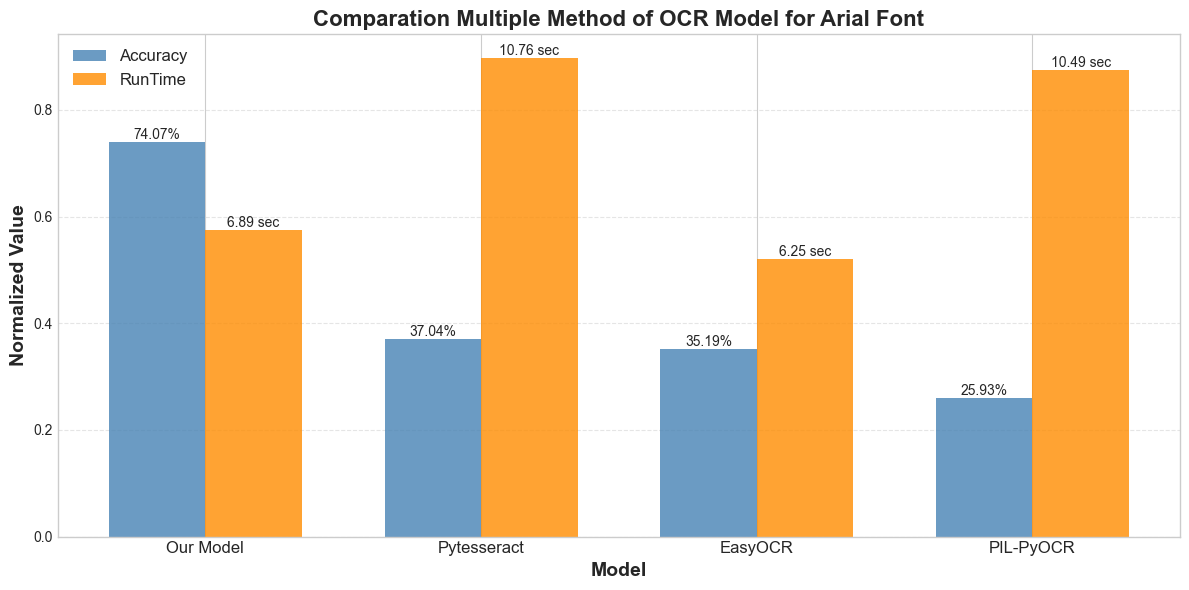

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x1 = np.array([74.07, 37.04, 35.19, 25.93])
x2 = np.array([6.89, 10.76, 6.25, 10.49])

x1_normalized = x1 / 100
x2_normalized = x2 / 12

plt.figure(figsize=(12, 6))

bar_width = 0.35

bar1 = plt.bar(np.arange(len(x1)), x1_normalized, color='steelblue', alpha=0.8, width=bar_width, label='Accuracy')
bar2 = plt.bar(np.arange(len(x2)) + bar_width, x2_normalized, color='darkorange', alpha=0.8, width=bar_width, label='RunTime')

plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('Normalized Value', fontsize=14, fontweight='bold')
plt.title('Comparation Multiple Method of OCR Model for Arial Font', fontsize=16, fontweight='bold')

plt.xticks(np.arange(len(x1)) + bar_width / 2, ['Our Model', 'Pytesseract', 'EasyOCR', 'PIL-PyOCR'], fontsize=12)
plt.legend(fontsize=12)

for bar in bar1:
    yval = bar.get_height() * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{yval:.2f}%', va='bottom', ha='center', fontsize=10)

for bar in bar2:
    yval = bar.get_height() * 12
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{yval:.2f} sec', va='bottom', ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
